In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from os import getenv
from dotenv import load_dotenv
import requests, random

In [ ]:
load_dotenv()

In [ ]:
# Fetch Store all free models
models = []
free_models = []
model_req_uri = getenv("OPENROUTER_URI") + "/models"
response = requests.get(model_req_uri)
for model in response.json()["data"]:
    if (
        model["pricing"]["prompt"] == "0"
        and model["pricing"]["completion"] == "0"
        and model["pricing"]["image"] == "0"
    ):
        free_models.append(
            {
                "id": model["id"],
                "name": model["name"],
                "context_length": model["context_length"],
                "modality": model["architecture"]["modality"],
                "tokenizer": model["architecture"]["tokenizer"],
                "pricing": model["pricing"],
                "max_completion_tokens": model["top_provider"]["max_completion_tokens"],
                "moderated": model["top_provider"]["is_moderated"],
                "request_limit": model["per_request_limits"],
            }
        )
    else:
        models.append(
            {
                "id": model["id"],
                "name": model["name"],
                "context_length": model["context_length"],
                "modality": model["architecture"]["modality"],
                "tokenizer": model["architecture"]["tokenizer"],
                "pricing": model["pricing"],
                "max_completion_tokens": model["top_provider"]["max_completion_tokens"],
                "moderated": model["top_provider"]["is_moderated"],
                "request_limit": model["per_request_limits"],
            }
        )

models.extend(free_models)

In [ ]:
text_models = [m for m in free_models if "image" not in m["modality"]]

random_text_model = random.choice(text_models)
print(random_text_model)

In [ ]:
if model:
    prompt = ChatPromptTemplate.from_template("tell me a joke about {topic}. 200 words")
    parser = StrOutputParser()
    llm = ChatOpenAI(
        api_key=getenv("OPENROUTER_TOKEN"),
        base_url=getenv("OPENROUTER_URI"),
        model=random_text_model["id"],
        tiktoken_model_name=random_text_model["tokenizer"],
        max_completion_tokens=random_text_model["max_completion_tokens"],
        temperature=0.1,
        streaming=True,
    )

    chain = prompt | llm | parser

In [ ]:
if chain:
    print(f"Model Used: {random_text_model['name']}")
    async for chunk in chain.astream({"topic": "parrot"}):
        print(chunk, end="", flush=True)

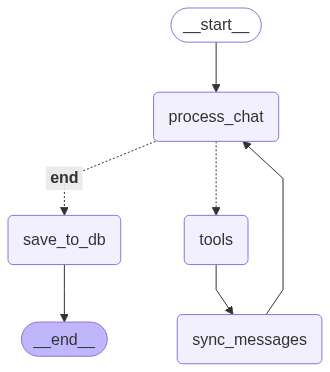

In [ ]:
import uuid, pickle, logging, re, asyncio
from pydantic import SecretStr
from sqlalchemy import update
from typing import TypedDict, Dict, Any, List, Optional, Sequence
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    AIMessageChunk,
    ToolMessage,
)
from pydantic import BaseModel, Field
from copy import deepcopy
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


class GraphState(TypedDict):
    user_id: uuid.UUID
    user_input: str
    chat_id: Optional[str]
    new_chat: bool
    messages: List[BaseMessage]
    token_usage: int
    tool_used: bool


builder = StateGraph(GraphState)


# Node 1: Process chat input
async def process_chat(state):
    return state


# Node 2: Save to database
async def save_to_db(state):
    return state


# Node: sync tool messages to store
async def sync_messages(state):
    return state


# Build graph
builder.add_node("process_chat", process_chat)
builder.add_node("tools", ToolNode([]))
builder.add_node("sync_messages", sync_messages)
builder.add_conditional_edges(
    "process_chat",
    tools_condition,
    {"tools": "tools", END: "save_to_db"},
)
builder.add_node("save_to_db", save_to_db)

# Define edges
builder.set_entry_point("process_chat")  # START
# Any time a tool is called, we return to the chatbot to decide the next step
builder.add_edge("tools", "sync_messages")
builder.add_edge("sync_messages", "process_chat")
builder.add_edge("save_to_db", END)

graph = builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass